In [29]:
!git clone https://github.com/Malikanhar/Face-Sketch-to-Image-Generation-using-GAN.git

Cloning into 'Face-Sketch-to-Image-Generation-using-GAN'...
remote: Enumerating objects: 885, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 885 (delta 46), reused 26 (delta 4), pack-reused 804
Receiving objects: 100% (885/885), 11.37 MiB | 13.98 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [30]:
import sys

In [31]:
%cd /content/Face-Sketch-to-Image-Generation-using-GAN

/content/Face-Sketch-to-Image-Generation-using-GAN


In [32]:
!ls

'Compute SSIM and L2-norm.ipynb'	     keras-contrib
 ContextualGAN.ipynb			     Models
'Data Augmentation.ipynb'		    'Predict Image.ipynb'
 Dataset				     readme.md
 Face-Sketch-to-Image-Generation-using-GAN   requirements.txt
'Generated Images'			     Testing.ipynb


In [33]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached absl-py-0.8.1.tar.gz (103 kB)
  Preparing metadata (setup.py) ... done
  Using cached astor-0.8.0-py2.py3-none-any.whl (27 kB)
  Using cached attrs-19.3.0-py2.py3-none-any.whl (39 kB)
  Using cached backcall-0.1.0.zip (11 kB)
  Preparing metadata (setup.py) ... done
  Using cached bleach-3.1.1-py2.py3-none-any.whl (150 kB)
  Using cached cachetools-3.1.1-py2.py3-none-any.whl (11 kB)
  Using cached certifi-2019.11.28-py2.py3-none-any.whl (156 kB)
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Using cached colorama-0.4.3-py2.py3-none-any.whl (15 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached decorator-4.4.1-py2.py3-none-any.whl (9.2 kB)
  Using cached defusedxml-0.6.0-py2.py3-none-any.whl (23 kB)
  Using cached entrypoints-0.3-py2.py3-none-any.whl (11 kB)
  Using cached gast-0.2.2.tar.gz (10 kB)
  Preparing metadata (setup.py) ... 

In [34]:
!git clone https://www.github.com/keras-team/keras-contrib.git

fatal: destination path 'keras-contrib' already exists and is not an empty directory.


In [35]:
%cd keras-contrib

/content/Face-Sketch-to-Image-Generation-using-GAN/keras-contrib


In [36]:
!python setup.py install

running install
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing keras_contrib.egg-info/PKG-INFO
writing dependency_links to keras_contrib.egg-info/dependency_links.txt
writing requirements to keras_contrib.egg-info/requires.txt
writing top-level names to keras_contrib.egg-info/top_level.txt
reading manifest file 'keras_contrib.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bd

In [37]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
import numpy as np
import glob
from PIL import Image

In [38]:
def random_shearing(img, num, border):
    rows = img.shape[0]
    cols = img.shape[1]
    if num == 0:
        pts1 = np.float32([[5,5],[20,5],[2,20]])
        pts2 = np.float32([[10,10],[20,5],[5,25]])
    elif num == 1:
        pts1 = np.float32([[5,5],[15,5],[2,20]])
        pts2 = np.float32([[5,10],[10,10],[5,25]])
    elif num == 2:
        pts1 = np.float32([[5,5],[15,5],[5,20]])
        pts2 = np.float32([[5,10],[10,10],[5,25]])
    elif num == 3:
        pts1 = np.float32([[5,5],[10,5],[2,20]])
        pts2 = np.float32([[5,10],[10,10],[5,25]])
    elif num == 4:
        pts1 = np.float32([[5,5],[10,5],[2,20]])
        pts2 = np.float32([[5,10],[10,10],[5,30]])
    else:
        pts1 = np.float32([[5,5],[10,5],[10,20]])
        pts2 = np.float32([[5,10],[10,10],[5,30]])
    M = cv2.getAffineTransform(pts1,pts2)
    return cv2.warpAffine(img, M, (cols,rows), borderValue=border)

def random_rotation(img, degree, border):
    rows = img.shape[0]
    cols = img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),degree,1)
    return cv2.warpAffine(img,M,(cols,rows), borderValue=border)

In [39]:
def transform_image(img, skt, ang_range, shear_range, trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    # Border
    idx = 0
    border_img = tuple([int(img[idx][0][0]), int(img[idx][0][1]), int(img[idx][0][2])])
    border_skt = tuple([int(skt[0][0][0]), int(skt[0][0][1]), int(skt[0][0][2])])
    
    img = cv2.warpAffine(img,Rot_M,(cols,rows), borderValue=border_img)
    img = cv2.warpAffine(img,Trans_M,(cols,rows), borderValue=border_img)
    img = cv2.warpAffine(img,shear_M,(cols,rows), borderValue=border_img)
    
    skt = cv2.warpAffine(skt,Rot_M,(cols,rows), borderValue=border_skt)
    skt = cv2.warpAffine(skt,Trans_M,(cols,rows), borderValue=border_skt)
    skt = cv2.warpAffine(skt,shear_M,(cols,rows), borderValue=border_skt)

    return img, skt

In [40]:
%cd /content/Face-Sketch-to-Image-Generation-using-GAN

/content/Face-Sketch-to-Image-Generation-using-GAN


In [41]:
sketch_dir = 'Dataset/Augmented sketch/'
photo_dir = 'Dataset/Augmented photo/'

if not os.path.exists(sketch_dir):
    os.mkdir(sketch_dir)

if not os.path.exists(photo_dir):
    os.mkdir(photo_dir)

p_filenames = glob.glob('Dataset/CUHK/Training photo/*')
s_filenames = glob.glob('Dataset/CUHK/Training sketch/*')

counter = 0
for i in range(len(p_filenames)):
    im = cv2.imread(p_filenames[i])
    sk = cv2.imread(s_filenames[i])

    for j in range(200):
        img, skt = transform_image(im, sk, 40, 10, 10)

        cv2.imwrite(photo_dir + str(counter) + '.jpg', img)
        cv2.imwrite(sketch_dir + str(counter) + '.jpg', skt)

        counter += 1

ls: cannot access 'Dataset/Augmented': No such file or directory
ls: cannot access 'sketch/': No such file or directory


In [9]:
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# from tensorflow.keras.utils import img_to_array
# from tensorflow.keras.utils import load_img
# from keras.models import load_model
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2

In [ ]:
g_model = load_model('Models/Pixel[1]_Context[0]/g_model.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

# # load and resize the image
# img = load_img('Dataset/CUHK/Testing sketch/m1-001-01-sz1.jpg', target_size=(256, 256))
# target = cv2.cvtColor(cv2.imread('Dataset/CUHK/Testing photo/m1-001-01.jpg'), cv2.COLOR_BGR2RGB)

# # convert to numpy array
# img = img_to_array(img)
# norm_img = (img.copy() - 127.5) / 127.5

# g_img = g_model.predict(np.expand_dims(norm_img, 0))[0]
# g_img = g_img * 127.5 + 127.5

# img = cv2.resize(img, (200, 250))
# g_img = cv2.resize(g_img, (200, 250))

# f = plt.figure(num=None, figsize=(12, 6), dpi=80)
# ax1 = f.add_subplot(1,3, 1)
# plt.imshow(img.astype('uint8'))
# ax2 = f.add_subplot(1,3, 2)
# plt.imshow(g_img.astype('uint8'))
# ax3 = f.add_subplot(1,3, 3)
# plt.imshow(target.astype('uint8'))
# ax1.set_title('Sketch')
# ax2.set_title('Generated Image')
# ax3.set_title('Target Image')

# plt.show(block=True)

OSError: ignored

In [42]:
from __future__ import print_function, division

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import natsort
import scipy
import sys
import os
import cv2

In [43]:
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

# load all images in a directory into memory
def load_images(list_path, size=(256, 256)):
    img_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in list_path:
        # load and resize the image
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

In [44]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    
    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y

In [45]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, dataset, target_dir='', n_samples=3):
    if target_dir and not os.path.exists(target_dir):
        os.mkdir(target_dir)
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(target_dir + filename1)
    plt.close()
    # save the generator model
    g_model.save(target_dir + 'g_model.h5')
    
    # save the discriminator model
    d_model.save(target_dir + 'd_model.h5')
    
    print('>Saved: %s and %s' % (filename1, 'g_model & d_model'))

In [46]:
def generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d
    
    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = InstanceNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d
    
    # Input Layer
    in_img = Input(shape=img_shape)
    
    # Downsampling
    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)
    
    # Upsampling
    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)
    
    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)
    
    return Model(in_img, out_img, name='generator')

In [47]:
def discriminator(img_shape):
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d
    
    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)
    
    merged = Concatenate()([in_src_img, in_target_img])
    
    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d1, 256)
    d4 = d_layer(d1, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
    
    return Model([in_src_img, in_target_img], out, name='discriminator')

In [48]:
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model

In [49]:
def train(d_model, g_model, gan_model, data, target_dir, n_epochs=100, n_batch=16):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    
    blue_photo = data[0]
    blue_sketch = data[1]
    
    for i in range(n_epochs):
        print(' ========== Epoch', i+1, '========== ')
        
        blue_photo, blue_sketch = shuffle(blue_photo, blue_sketch)

        for j in range(int(len(blue_photo)/n_batch)):
            
            start = int(j*n_batch)
            end = int(min(len(blue_photo), (j*n_batch)+n_batch))
            
            dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]

            # select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
            
            # generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
            
            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
            
            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
            
            d_loss = 0.5 * np.add(d_loss1, d_loss2)
            
            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
            
            # summarize performance
            print('Batch : %d, D Loss : %.3f | G Loss : %.3f' % (j+1, d_loss, g_loss))
        
        # summarize model performance
#         if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, target_dir)

In [63]:
import tensorflow as tf
import keras.backend as K
from keras.losses import mean_absolute_error

def pixel_loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def contextual_loss (y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(
                                y_pred, 
                                [0,0,0,0], 
                                [16, 256, 256, 3]))
    
    b = tf.image.rgb_to_grayscale(tf.slice(
                                y_true, 
                                [0,0,0,0], 
                                [16, 256, 256, 3]))
    
    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)
    
#     tf.assert_rank(y_true,2)
#     tf.assert_rank(y_pred,2)
    
    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)
#     tf.assert_equal(p_shape, q_shape)
    
    # normalize sum to 1
    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1,p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1,p_shape[1]]))
    
    return tf.reduce_sum(tf.multiply(p_, tf.math.log(tf.divide(p_, q_))), axis=1)

def total_loss (y_true, y_pred):

    px_loss = pixel_loss(y_true, y_pred)

    ctx_loss = contextual_loss(y_true, y_pred)
    
    return (0.2 * px_loss) + (0.8 * ctx_loss)

In [64]:
# dataset path
b_photo_path = 'Dataset/Augmented photo/'
b_sketch_path = 'Dataset/Augmented sketch/'

blue_photo = load_filename(b_photo_path)
blue_sketch = load_filename(b_sketch_path)

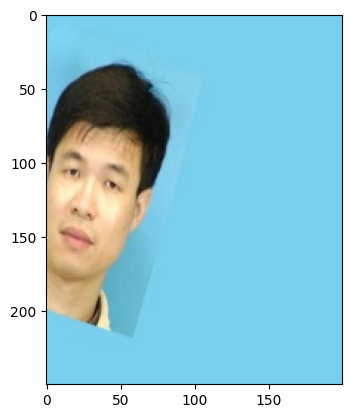

In [65]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[10]).astype('uint8'), cv2.COLOR_BGR2RGB))

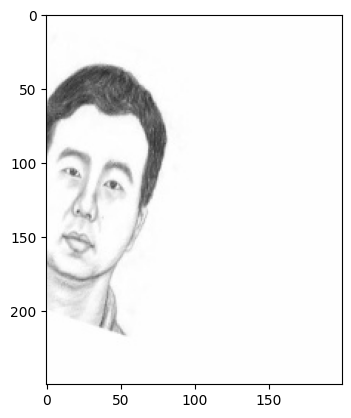

In [66]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_sketch[10]).astype('uint8'), cv2.COLOR_BGR2RGB))

In [67]:
img_shape = (256, 256, 3)

d_model = discriminator(img_shape)

g_model = generator(img_shape)

gan_model = GAN(g_model, d_model, img_shape)

In [68]:
gan_model.summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 generator (Functional)         (None, 256, 256, 3)  41825691    ['input_8[0][0]']                
                                                                                                  
 discriminator (Functional)     (None, 64, 64, 1)    539203      ['input_8[0][0]',                
                                                                  'generator[0][0]']              
                                                                                                

In [69]:
opt = Adam(learning_rate=2e-4, beta_1=0.5)

d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

In [ ]:
train(d_model, g_model, gan_model, [blue_sketch, blue_photo], 'Models/Pixel[02]_Context[08]/', n_epochs = 100, n_batch=16)

 ========== Epoch 1 ========== 
1/1 [==============================] - 0s 457ms/step
Batch : 1, D Loss : 3.200 | G Loss : 20.438
1/1 [==============================] - 0s 36ms/step
Batch : 2, D Loss : 3.812 | G Loss : 16.700
1/1 [==============================] - 0s 33ms/step
Batch : 3, D Loss : 3.666 | G Loss : 18.309
1/1 [==============================] - 0s 36ms/step
Batch : 4, D Loss : 3.806 | G Loss : 13.017
1/1 [==============================] - 0s 33ms/step
Batch : 5, D Loss : 3.815 | G Loss : 16.392
1/1 [==============================] - 0s 31ms/step
Batch : 6, D Loss : 3.847 | G Loss : 17.725
1/1 [==============================] - 0s 54ms/step
Batch : 7, D Loss : 3.908 | G Loss : 14.644
1/1 [==============================] - 0s 33ms/step
Batch : 8, D Loss : 3.702 | G Loss : 14.721
1/1 [==============================] - 0s 32ms/step
Batch : 9, D Loss : 3.817 | G Loss : 12.265
1/1 [==============================] - 0s 31ms/step
Batch : 10, D Loss : 3.717 | G Loss : 17.618
1/1 [=

>Saved: plot_000001.png and g_model & d_model
 ========== Epoch 2 ========== 
1/1 [==============================] - 0s 32ms/step
Batch : 1, D Loss : 3.595 | G Loss : 9.491
1/1 [==============================] - 0s 33ms/step
Batch : 2, D Loss : 3.810 | G Loss : 11.145
1/1 [==============================] - 0s 36ms/step
Batch : 3, D Loss : 3.689 | G Loss : 9.007
1/1 [==============================] - 0s 43ms/step
Batch : 4, D Loss : 3.790 | G Loss : 8.643
1/1 [==============================] - 0s 32ms/step
Batch : 5, D Loss : 3.833 | G Loss : 9.121
1/1 [==============================] - 0s 35ms/step
Batch : 6, D Loss : 3.767 | G Loss : 9.106
1/1 [==============================] - 0s 33ms/step
Batch : 7, D Loss : 3.607 | G Loss : 9.399
1/1 [==============================] - 0s 33ms/step
Batch : 8, D Loss : 3.813 | G Loss : 9.203
1/1 [==============================] - 0s 38ms/step
Batch : 9, D Loss : 3.803 | G Loss : 9.986
1/1 [==============================] - 0s 54ms/step
Batch : 10, D 

>Saved: plot_000002.png and g_model & d_model
 ========== Epoch 3 ========== 
1/1 [==============================] - 0s 39ms/step
Batch : 1, D Loss : 3.803 | G Loss : 8.044
1/1 [==============================] - 0s 35ms/step
Batch : 2, D Loss : 3.797 | G Loss : 9.694
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.733 | G Loss : 8.770
1/1 [==============================] - 0s 31ms/step
Batch : 4, D Loss : 3.730 | G Loss : 7.106
1/1 [==============================] - 0s 37ms/step
Batch : 5, D Loss : 3.659 | G Loss : 6.023
1/1 [==============================] - 0s 33ms/step
Batch : 6, D Loss : 3.781 | G Loss : 8.484
1/1 [==============================] - 0s 34ms/step
Batch : 7, D Loss : 3.795 | G Loss : 8.624
1/1 [==============================] - 0s 36ms/step
Batch : 8, D Loss : 3.777 | G Loss : 8.411
1/1 [==============================] - 0s 31ms/step
Batch : 9, D Loss : 3.789 | G Loss : 8.488
1/1 [==============================] - 0s 31ms/step
Batch : 10, D L

>Saved: plot_000003.png and g_model & d_model
 ========== Epoch 4 ========== 
1/1 [==============================] - 0s 50ms/step
Batch : 1, D Loss : 3.652 | G Loss : 8.266
1/1 [==============================] - 0s 30ms/step
Batch : 2, D Loss : 3.664 | G Loss : 7.749
1/1 [==============================] - 0s 29ms/step
Batch : 3, D Loss : 3.621 | G Loss : 6.277
1/1 [==============================] - 0s 34ms/step
Batch : 4, D Loss : 3.699 | G Loss : 7.937
1/1 [==============================] - 0s 33ms/step
Batch : 5, D Loss : 3.864 | G Loss : 8.213
1/1 [==============================] - 0s 30ms/step
Batch : 6, D Loss : 3.792 | G Loss : 7.050
1/1 [==============================] - 0s 32ms/step
Batch : 7, D Loss : 3.787 | G Loss : 7.590
1/1 [==============================] - 0s 31ms/step
Batch : 8, D Loss : 3.768 | G Loss : 7.887
1/1 [==============================] - 0s 31ms/step
Batch : 9, D Loss : 3.731 | G Loss : 7.266
1/1 [==============================] - 0s 43ms/step
Batch : 10, D L

>Saved: plot_000004.png and g_model & d_model
 ========== Epoch 5 ========== 
1/1 [==============================] - 0s 28ms/step
Batch : 1, D Loss : 3.630 | G Loss : 6.196
1/1 [==============================] - 0s 29ms/step
Batch : 2, D Loss : 3.676 | G Loss : 8.582
1/1 [==============================] - 0s 43ms/step
Batch : 3, D Loss : 3.682 | G Loss : 6.855
1/1 [==============================] - 0s 28ms/step
Batch : 4, D Loss : 3.626 | G Loss : 7.587
1/1 [==============================] - 0s 33ms/step
Batch : 5, D Loss : 3.841 | G Loss : 6.654
1/1 [==============================] - 0s 31ms/step
Batch : 6, D Loss : 3.766 | G Loss : 6.980
1/1 [==============================] - 0s 30ms/step
Batch : 7, D Loss : 3.778 | G Loss : 8.365
1/1 [==============================] - 0s 28ms/step
Batch : 8, D Loss : 3.740 | G Loss : 7.967
1/1 [==============================] - 0s 34ms/step
Batch : 9, D Loss : 3.757 | G Loss : 7.947
1/1 [==============================] - 0s 32ms/step
Batch : 10, D L

>Saved: plot_000005.png and g_model & d_model
 ========== Epoch 6 ========== 
1/1 [==============================] - 0s 32ms/step
Batch : 1, D Loss : 3.719 | G Loss : 6.705
1/1 [==============================] - 0s 29ms/step
Batch : 2, D Loss : 3.579 | G Loss : 7.028
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 3.718 | G Loss : 7.550
1/1 [==============================] - 0s 27ms/step
Batch : 4, D Loss : 3.647 | G Loss : 6.709
1/1 [==============================] - 0s 28ms/step
Batch : 5, D Loss : 3.614 | G Loss : 6.431
1/1 [==============================] - 0s 27ms/step
Batch : 6, D Loss : 3.768 | G Loss : 5.883
1/1 [==============================] - 0s 29ms/step
Batch : 7, D Loss : 3.624 | G Loss : 6.445
1/1 [==============================] - 0s 27ms/step
Batch : 8, D Loss : 3.857 | G Loss : 8.224
1/1 [==============================] - 0s 28ms/step
Batch : 9, D Loss : 3.764 | G Loss : 7.488
1/1 [==============================] - 0s 28ms/step
Batch : 10, D L

>Saved: plot_000006.png and g_model & d_model
 ========== Epoch 7 ========== 
1/1 [==============================] - 0s 29ms/step
Batch : 1, D Loss : 3.664 | G Loss : 7.975
1/1 [==============================] - 0s 29ms/step
Batch : 2, D Loss : 3.638 | G Loss : 6.587
1/1 [==============================] - 0s 57ms/step
Batch : 3, D Loss : 3.726 | G Loss : 7.865
1/1 [==============================] - 0s 29ms/step
Batch : 4, D Loss : 3.654 | G Loss : 7.633
1/1 [==============================] - 0s 34ms/step
Batch : 5, D Loss : 3.762 | G Loss : 7.072
1/1 [==============================] - 0s 48ms/step
Batch : 6, D Loss : 3.736 | G Loss : 5.823
1/1 [==============================] - 0s 29ms/step
Batch : 7, D Loss : 3.573 | G Loss : 8.071
1/1 [==============================] - 0s 30ms/step
Batch : 8, D Loss : 3.692 | G Loss : 6.605
1/1 [==============================] - 0s 27ms/step
Batch : 9, D Loss : 3.770 | G Loss : 7.108
1/1 [==============================] - 0s 29ms/step
Batch : 10, D L

In [ ]:
files.download('/content/sample_data.zip')